In [1]:
import os

import coiled
import dask
import numpy as np
import thermofeel as tf
import xarray as xr
import xclim
from utils import gcm_list, load_nasanex, wbgt

os.environ["USE_PYGEOS"] = "0"

# notes - run Fri Jan 24th at 9:43 with impacts-extreme-heat-02-min env

In [2]:
# mamba env create -n my-env-name -f lock-file.yaml

In [2]:
def adjust_pressure(temperature, elevation):
    """
    Approximate surface pressure given the elevation and temperature.
    Method from https://doi.org/10.1038/s41598-019-50047-w
    """
    return 101325 * np.power(10, -elevation / (18400 * temperature / 273.15))

In [3]:
cluster = coiled.Cluster(
    n_workers=4,
    name="02",
    worker_vm_types=["m7g.2xlarge"],
    scheduler_vm_types=["c7g.2xlarge"],
    region="us-west-2",
    spot_policy="spot_with_fallback",
)

cluster.adapt(minimum=1, maximum=200)

client = cluster.get_client()

[2025-01-24 10:06:05,682][INFO    ][coiled] Fetching latest package priorities...
[2025-01-24 10:06:05,683][INFO    ][coiled.package_sync] Resolving your local impacts-extreme-heat-02-min Python environment...
[2025-01-24 10:06:06,108][INFO    ][coiled.package_sync] Scanning 235 conda packages...
[2025-01-24 10:06:06,110][INFO    ][coiled.package_sync] Scanning 167 python packages...
[2025-01-24 10:06:06,459][INFO    ][coiled] Running pip check...
[2025-01-24 10:06:07,551][INFO    ][coiled] Validating environment...
[2025-01-24 10:06:09,785][INFO    ][coiled] Creating wheel for ~/Documents/carbonplan/extreme-heat-extension/central_asia/notebooks...
[2025-01-24 10:06:09,881][INFO    ][coiled] Uploading coiled_local_notebooks...
[2025-01-24 10:06:10,859][INFO    ][coiled] Requesting package sync build...
[2025-01-24 10:06:12,169][INFO    ][coiled] Creating Cluster (name: 02, https://cloud.coiled.io/clusters/739246?account=carbonplan ). This usually takes 1-2 minutes...
2025-01-24 10:07:3

In [4]:
elev = xr.open_zarr(
    "s3://carbonplan-climate-impacts/extreme-heat/v1.0/inputs/elevation.zarr"
)
elev = elev.chunk({"lat": -1, "lon": -1}).compute()

In [6]:
scenario_years = {
    "historical": np.arange(1985, 1986),
}

In [7]:
generate_wbgt_projections = True
variables = ["tasmax", "huss", "tas"]
if generate_wbgt_projections:
    for gcm in ["ACCESS-CM2"]:
        for scenario, years in scenario_years.items():
            id_string = f"{gcm}-{scenario}"
            print(id_string)
            # try:
            for year in years[0:1]:
                print(year)
                output = (
                    f"s3://carbonplan-scratch/extreme-heat-extension/wbgt-shade-"
                    f"gridded/years/{gcm}/{id_string}-{year}-raph.zarr"
                )
                ds = load_nasanex(
                    gcm=gcm, scenario=scenario, variables=variables, years=[year],
                    chunk_dict={'time': 40}
                )
                # calculate elevation-adjusted pressure
                ds["ps"] = xr.apply_ufunc(
                    adjust_pressure, ds["tas"], elev, dask="allowed"
                ).rename({"elevation": "ps"})["ps"]
                ds["ps"].attrs["units"] = "Pa"
                ds["hurs"] = xclim.indices.relative_humidity(
                    tas=ds["tasmax"], huss=ds["huss"], ps=ds["ps"]
                )
                ds["tasmax"].attrs = {}

                # windspeed assumption of 0.5 m/s (approximating shaded/indoor
                # conditions)
                ds["sfcWind"] = (ds["tas"] - ds["tas"]) + 0.5
                ds["WBT"] = tf.thermofeel.calculate_wbt(
                    ds["tasmax"] - 273.15, ds["hurs"]
                )

                ds["BGT"] = tf.thermofeel.calculate_bgt(
                    ds["tasmax"], ds["tasmax"], ds["sfcWind"]
                )
                ds["WBGT"] = wbgt(ds["WBT"], ds["BGT"], ds["tasmax"] - 273.15)
                ds["WBGT"].attrs["units"] = "degC"
                ds = ds[["WBGT"]]
                ds = dask.optimize(ds)[0]
                t = ds.to_zarr(output, consolidated=True, mode="w", compute=False)
                t.compute()


ACCESS-CM2-historical
1985


In [12]:
cluster.shutdown()

2025-01-24 10:09:06,142 - distributed.deploy.adaptive_core - INFO - Adaptive stop
[2025-01-24 10:09:06,399][INFO    ][coiled] Cluster 739246 deleted successfully.
2025-01-24 10:09:06,399 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [13]:
gcm  ="ACCESS-CM2"
scenario = "historical"
id_string = f"{gcm}-{scenario}"


In [14]:

ds_ori = xr.open_zarr(f"s3://carbonplan-scratch/extreme-heat-extension/wbgt-shade-gridded/years/{gcm}/{id_string}-{year}-ori.zarr", chunks={})

In [15]:

ds_raph = xr.open_zarr(f"s3://carbonplan-scratch/extreme-heat-extension/wbgt-shade-gridded/years/{gcm}/{id_string}-{year}-raph.zarr", chunks={})

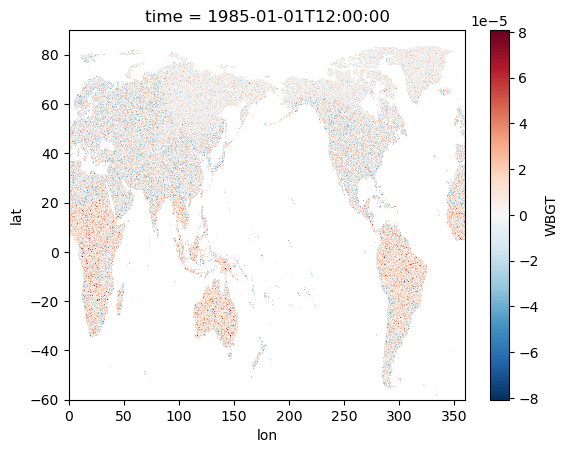

In [16]:
# nicest_code = xr.open_zarr('s3://carbonplan-scratch/extreme-heat/wbgt-shade-gridded/years/ACCESS-CM2/ACCESS-CM2-historical_impacts-impacts-extreme-heat-test-env.zarr')
(ds_ori.sel(time=slice("1985-01-01","1985-12-31")).isel(time=0)-ds_raph.sel(time=slice("1985-01-01","1985-12-31")).isel(time=0)).WBGT.plot()

In [11]:

# ds = xr.open_zarr(f"s3://carbonplan-scratch/extreme-heat/wbgt-shade-gridded/years/{gcm}/{id_string}_impacts-impacts-extreme-heat-test-env.zarr", chunks={}).sel(time=slice("1985-01-01","1985-12-31"))

In [ ]:
# ds.isel(time=slice(0,10)).sel(lat=50,lon=50, method='nearest').hvplot()

In [ ]:
# import hvplot.xarray  # noqa
# (ds.hvplot(label='og') * ds_raph.hvplot(label='raph') ).opts(
#     legend_position='top_left'
# )
# #* ds_raph.hvplot(label='ori')